# LogP optimization with ReLeaSE algorithm

In this experiment we will optimized parameters of pretrained generative RNN to produce molecules with values of logP within drug-like region according to Lipinsky rule. We use policy gradient algorithm with custom reward function to bias the properties of generated molecules aka Reinforcement Learninf for Structural Evolution (ReLeaSE) as was proposed in **Popova, M., Isayev, O., & Tropsha, A. (2018). *Deep reinforcement learning for de novo drug design*. Science advances, 4(7), eaap7885.** 

## Imports

In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys

In [4]:
sys.path.append('./release/')

In [5]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR, StepLR
import torch.nn.functional as F

In [6]:
use_cuda = torch.cuda.is_available()

In [7]:
import numpy as np
from tqdm import tqdm, trange
import pickle
from rdkit import Chem, DataStructs
from stackRNN import StackAugmentedRNN
from data import GeneratorData 
from utils import canonical_smiles

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

## Setting up the generator

### Loading data for the generator

In [9]:
gen_data_path = './data/chembl_22_clean_1576904_sorted_std_final.smi'

In [10]:
tokens = ['<', '>', '#', '%', ')', '(', '+', '-', '/', '.', '1', '0', '3', '2', '5', '4', '7',
          '6', '9', '8', '=', 'A', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'P', 'S', '[', ']',
          '\\', 'c', 'e', 'i', 'l', 'o', 'n', 'p', 's', 'r', '\n']

In [11]:
gen_data = GeneratorData(training_data_path=gen_data_path, delimiter='\t', 
                         cols_to_read=[0], keep_header=True, tokens=tokens)

## Util functions

**plot_hist** function plots histogram of predicted properties and a vertical line for thershold.

In [12]:
def plot_hist(prediction, n_to_generate):
    prediction = np.array(prediction)
    percentage_in_threshold = np.sum((prediction >= 0.0) & 
                                     (prediction <= 5.0))/len(prediction)
    print("Percentage of predictions within drug-like region:", percentage_in_threshold)
    print("Proportion of valid SMILES:", len(prediction)/n_to_generate)
    ax = sns.kdeplot(prediction, shade=True)
    plt.axvline(x=0.0)
    plt.axvline(x=5.0)
    ax.set(xlabel='Predicted LogP', 
           title='Distribution of predicted LogP for generated molecules')
    plt.show()

**estimate_and_update** function:

1) generates n_to_generate number of SMILES strings

2) filters invalid SMILES

3) predicts logP for valid SMILES

4) plots histogram of predicted logP

5) Returns valid SMILES and their predicted logPs

In [13]:
def estimate_and_update(generator, predictor, n_to_generate):
    generated = []
    pbar = tqdm(range(n_to_generate))
    for i in pbar:
        pbar.set_description("Generating molecules...")
        generated.append(generator.evaluate(gen_data, predict_len=120)[1:-1])

    sanitized = canonical_smiles(generated, sanitize=False, throw_warning=False)[:-1]
    unique_smiles = list(np.unique(sanitized))[1:]
    smiles, prediction, nan_smiles = predictor.predict(unique_smiles, use_tqdm=True)  
                                                       
    plot_hist(prediction, n_to_generate)
        
    return smiles, prediction

## Initializing and training the generator

We will used stack augmented generative GRU as a generator. The model was trained to predict the next symbol from SMILES alphabet using the already generated prefix. Model was trained to minimize the cross-entropy loss between predicted symbol and ground truth symbol. Scheme of the generator when inferring new SMILES is shown below:

<img src="./figures/generator.png">

Initialize stack-augmented generative RNN:

In [14]:
hidden_size = 1500
stack_width = 1500
stack_depth = 200
layer_type = 'GRU'
lr = 0.001
optimizer_instance = torch.optim.Adadelta

my_generator = StackAugmentedRNN(input_size=gen_data.n_characters, hidden_size=hidden_size,
                                 output_size=gen_data.n_characters, layer_type=layer_type,
                                 n_layers=1, is_bidirectional=False, has_stack=True,
                                 stack_width=stack_width, stack_depth=stack_depth, 
                                 use_cuda=use_cuda, 
                                 optimizer_instance=optimizer_instance, lr=lr)

If you want train the model from scratch, uncomment the lines below:

In [15]:
model_path = './checkpoints/generator/checkpoint_biggest_rnn'

In [16]:
#losses = my_generator.fit(gen_data, 1500000)

In [17]:
#plt.plot(losses)

In [18]:
#my_generator.evaluate(gen_data)

In [19]:
#my_generator.save_model(model_path)

Alternatively, you can skip the process of training and load the pretrained parameters into the model:

In [20]:
my_generator.load_model(model_path)

## Setting up the predictor

For this demo we will use Recurrent Neural Network, i.e. unidirectional LSTM with 2 layers. The network is trained in 5-fold cross validation manner using the OpenChem toolkit (https://github.com/Mariewelt/OpenChem). In this demo we only upload the pretrained model. The training demo is in *RecurrentQSAR-example-logp.ipynb* file in the same directory. 

In [21]:
! git clone --single-branch --branch develop https://github.com/Mariewelt/OpenChem.git

Cloning into 'OpenChem'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 1551 (delta 19), reused 31 (delta 6), pack-reused 1492
Receiving objects: 100% (1551/1551), 108.61 MiB | 63.90 MiB/s, done.
Resolving deltas: 100% (776/776), done.
Checking connectivity... done.


In [22]:
sys.path.append('./OpenChem/')

In [23]:
from rnn_predictor import RNNPredictor

In [24]:
predictor_tokens = tokens + [' ']

In [25]:
path_to_params = './checkpoints/logP/model_parameters.pkl'
path_to_checkpoint = './checkpoints/logP/fold_'

In [26]:
my_predictor = RNNPredictor(path_to_params, path_to_checkpoint, predictor_tokens)

Here we produce the unbiased distribution of the property:

Calculating predictions...:  100%|█████████▊| 7685/7685 [00:05<00:00, 1265.07it/s]


Percentage of predictions within drug-like region: 0.886402081977879
Proportion of valid SMILES: 0.7685


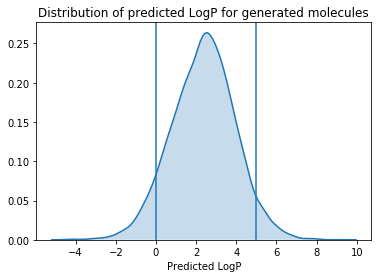

In [27]:
smiles_unbiased, prediction_unbiased = estimate_and_update(my_generator,
                                                           my_predictor,
                                                           n_to_generate=10000)

## Biasing the distribution of the generator with reinforcement learning (policy gradient)

We combine the generator and the predictor into a single pipeline. The generator produces new SMILES string, which is then evaluated by the predictor. Based on the obtain prediction and our goal, we assign a numerical reward value and update the parameters of the generator using policy gradient algorithm.

<img src="./figures/rl_pipeline.png">

Policy gradient loss is defined as:
$$
L(S|\theta) = -\dfrac{1}{n}\sum_{i=1}^{|S|} \sum_{j=1}^{length(s_i)} R_i\cdot \gamma^i \cdot \log p(s_i|s_0 \dots s_{i-1}\theta),
$$

where $R_i$ is the reward obtained at time step $i$ $\gamma$ is the discount factor and $p(s_i|s_0 \dots s_{i-1}, \theta)$ is the probability of the next character given the prefix, which we obtain from the generator. 

In our case the reward is the same for every time step and is equal to the reward for the whole molecule. Discount factor $\gamma$ is a number close to $1.0$ (it could be $1.0$).

### Optimizing logP to be in drug like region

In [28]:
from reinforcement import Reinforcement

Making a copy of the generator that will be optimized

In [29]:
my_generator_max = StackAugmentedRNN(input_size=gen_data.n_characters, 
                                     hidden_size=hidden_size,
                                     output_size=gen_data.n_characters, 
                                     layer_type=layer_type,
                                     n_layers=1, is_bidirectional=False, has_stack=True,
                                     stack_width=stack_width, stack_depth=stack_depth, 
                                     use_cuda=use_cuda, 
                                     optimizer_instance=optimizer_instance, lr=lr)

my_generator_max.load_model(model_path)

In [30]:
# Setting up some parameters for the experiment
n_to_generate = 200
n_policy_replay = 10
n_policy = 15
n_iterations = 60

In [31]:
def simple_moving_average(previous_values, new_value, ma_window_size=10):
    value_ma = np.sum(previous_values[-(ma_window_size-1):]) + new_value
    value_ma = value_ma/(len(previous_values[-(ma_window_size-1):]) + 1)
    return value_ma

The reward function we will use here is the following:

$$
R =  \begin{cases} 11.0, & \mbox{if } 1.0 < \log P < 4.0 \\ 1.0, & \mbox{otherwise}  \end{cases}
$$

In [32]:
def get_reward_logp(smiles, predictor, invalid_reward=0.0):
    mol, prop, nan_smiles = predictor.predict([smiles])
    if len(nan_smiles) == 1:
        return invalid_reward
    if (prop[0] >= 1.0) and (prop[0] <= 4.0):
        return 11.0
    else:
        return 1.0

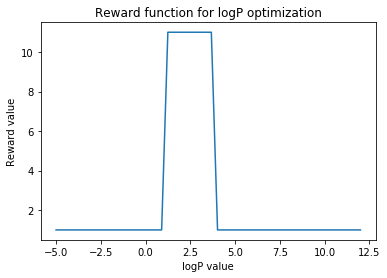

In [33]:
x = np.linspace(-5, 12)
reward = lambda x: 11.0 if ((x > 1.0) and (x < 4.0)) else 1.0
plt.plot(x, [reward(i) for i in x])
plt.xlabel('logP value')
plt.ylabel('Reward value')
plt.title('Reward function for logP optimization')
plt.show()

In [34]:
RL_logp = Reinforcement(my_generator_max, my_predictor, get_reward_logp)

In [35]:
rewards = []
rl_losses = []

Policy gradient...: 100%|██████████| 15/15 [00:42<00:00,  2.75s/it]


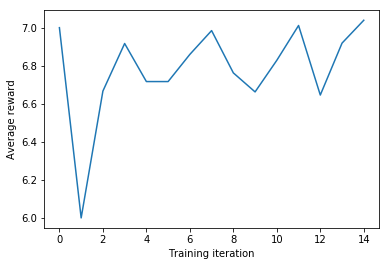

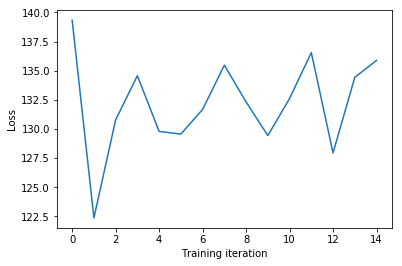

Calculating predictions...: 100%|██████████| 156/156 [00:00<00:00, 1166.87it/s]


Percentage of predictions within drug-like region: 0.8717948717948718
Proportion of valid SMILES: 0.78


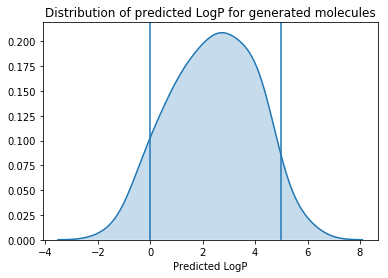

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
C                                                                                                                
C=C1CCC2(C)CCC(=O)C(C)C1CC(=O)C1(C)c3cc(CBr)ccc3C1CCC2C1C=C(C)CCC(C)(CC)C1(C)O                                   
C=C1Oc2ccccc2c2(ccc(OC)c(OC)c2)N=C1C(=O)c1ccccc1                                                                 
C=CC1(O)C(=O)C=C(N(C)C)C1=O                                                                                      
C=CC=NNC(=O)c1cc2cc(OC(Cc3ccccc3)c3ccccc3)CC(=O)cnc2cc1O                                                         


Policy gradient...: 100%|██████████| 15/15 [00:41<00:00,  2.75s/it]


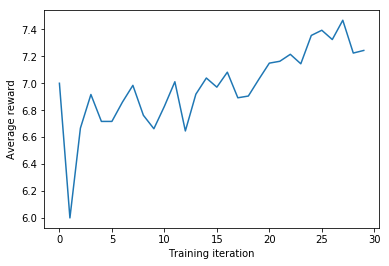

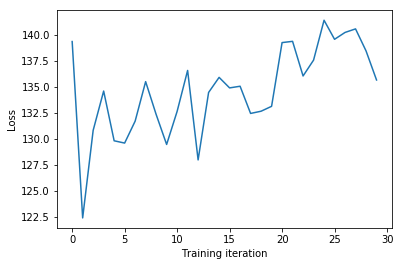

Calculating predictions...: 100%|██████████| 154/154 [00:00<00:00, 1173.51it/s]


Percentage of predictions within drug-like region: 0.8831168831168831
Proportion of valid SMILES: 0.77


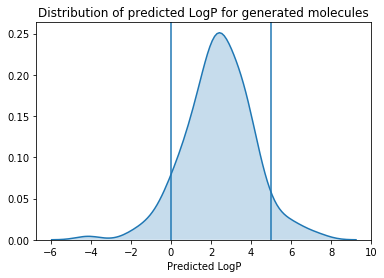

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
C#CCN(C)C=C(COC(=O)c1ccc(N(C)C)cc1)c1ccccc1                                                 
C=C1CS(=O)(=O)n=C(SC)C1C#N                                                                  
C=CCN(C(C)=O)c1cc(OCCN)ccc1-c1cncc(c2ccc(F)cc2)-c2ccc(n1)CN1CCN(CC1)C(=O)C(=O)N2            
CC(=O)CC1(CCOC(N)=O)CC1CBr                                                                  
CC(=O)Nc1ccc(-n2nnnc2C(=O)NC2CCCCC2)cc1                                                     


Policy gradient...: 100%|██████████| 15/15 [00:41<00:00,  2.69s/it]


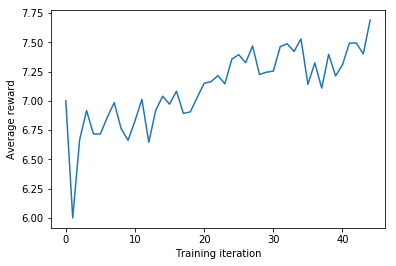

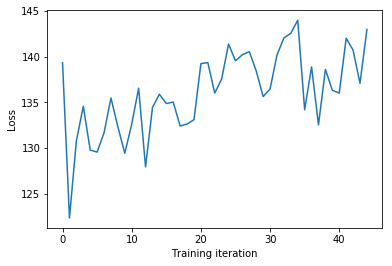

Calculating predictions...: 100%|██████████| 153/153 [00:00<00:00, 1846.07it/s]


Percentage of predictions within drug-like region: 0.8888888888888888
Proportion of valid SMILES: 0.765


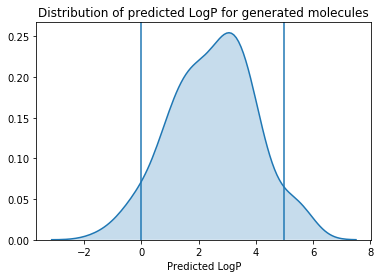

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
CC(=Cc1c(C)nn(C(C)C)c1C(=O)O)N1C(C)CCCC1C                                             
CC(=O)Nc1ccc2c(c1)C(CNC(c1ccccc1)c1ccccc1)=CC(=O)O2                                   
CC(C)(C)NC(=O)Nc1ccc2c(c1)C=C(Nc1cc3nn-c(cccc(Cl)c1F)Cc1cc(Cl)ccc13)C(=O)N2           
CC(C)(C)c1cc(C(N)NC2CCCCC2)ccc1O                                                      
CC(C)C(NC(=O)c1cccc(Cl)c1)C(O)CO                                                      


Policy gradient...: 100%|██████████| 15/15 [00:39<00:00,  2.45s/it]


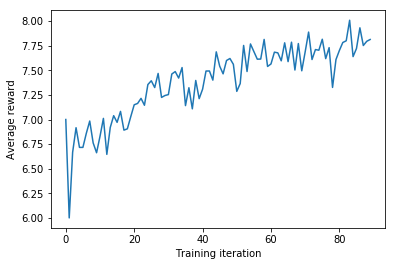

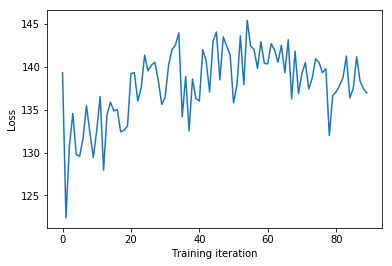

Calculating predictions...: 100%|██████████| 157/157 [00:00<00:00, 946.23it/s]


Percentage of predictions within drug-like region: 0.8853503184713376
Proportion of valid SMILES: 0.785


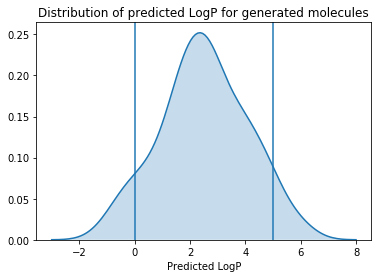

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
C                                                                                
C=C(C)C1=C(O)C=C(c2ccc(OC)cc2)C(=C)C1=O                                          
C=CC1=CC(C(=O)OC)=Cc2ccccc21                                                     
C=CCN(Cc1ccccc1C)C(=O)c1ccc(S(N)(=O)=O)cc1                                       
CC(=O)NCC1CN(c2cccc3nc(C4CC4)sc23)C(=O)O1                                        


Policy gradient...: 100%|██████████| 15/15 [00:38<00:00,  2.69s/it]


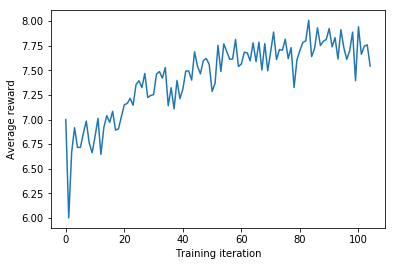

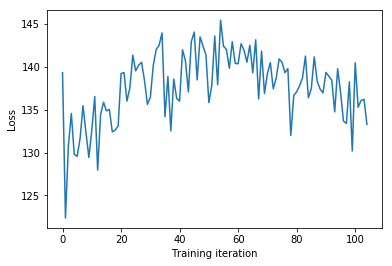

Calculating predictions...: 100%|██████████| 158/158 [00:00<00:00, 1271.56it/s]


Percentage of predictions within drug-like region: 0.8987341772151899
Proportion of valid SMILES: 0.79


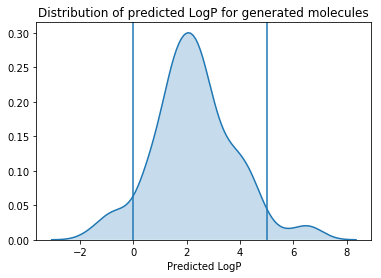

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
C=C(CC(=O)Nc1ccc(Cl)c(F)c1)C1CC(=O)N(C)C1=O                                     
C=C1CC(O)(Cc2ccc(O)c3ccccc23)C(O)C1CC                                           
C=CC(=O)c1ccc(Cl)c(NC(=O)CN2C=C(C)C(=O)c3ccccc32)c1                             
CC(=NN=Cc1cccnc1)c1cccn1C                                                       
CC(=O)N1CCN=C1C(C)=NNC(=O)NC1CCCC1                                              


Policy gradient...: 100%|██████████| 15/15 [00:40<00:00,  2.61s/it]


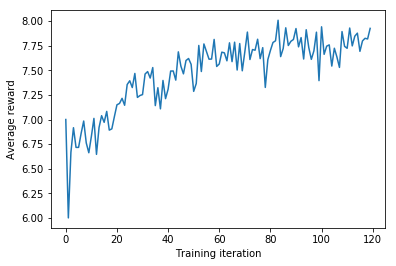

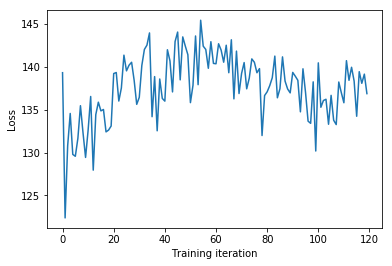

Calculating predictions...: 100%|██████████| 164/164 [00:00<00:00, 1732.47it/s]


Percentage of predictions within drug-like region: 0.8719512195121951
Proportion of valid SMILES: 0.82


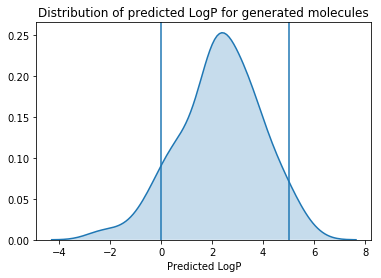

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
C=Nc1cnc(C(C)(C)c2ccccc2)cc1c1cc(-c2cccc(OC)c2)n1                                          
C=S(=O)(COC(=O)c1ccccc1)c1ccc(OC)cc1                                                       
CC(=O)C(NC(=O)Oc1ccccc1C(=O)c1ccccc1)NC(=O)C1CCCC1                                         
CC(=O)N(CC(F)(F)F)C(=O)CC1C(N(C)CCc2ccc(Cl)cc2F)C(C)C2CCC(C)C21C                           
CC(=O)N1CCn2c(nnc2-c2cccc(C(=O)NCc3ccccc3Cl)c2)C1                                          


Policy gradient...: 100%|██████████| 15/15 [00:39<00:00,  2.55s/it]


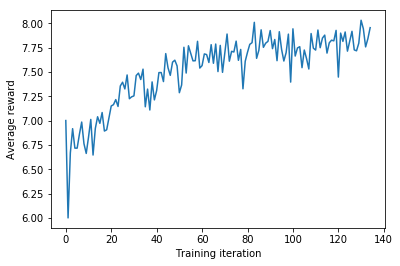

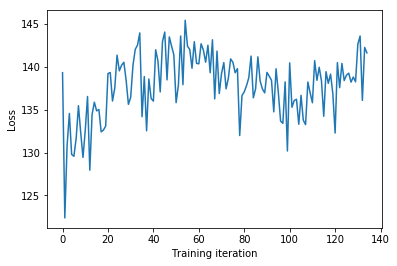

Calculating predictions...: 100%|██████████| 158/158 [00:00<00:00, 1156.11it/s]


Percentage of predictions within drug-like region: 0.9050632911392406
Proportion of valid SMILES: 0.79


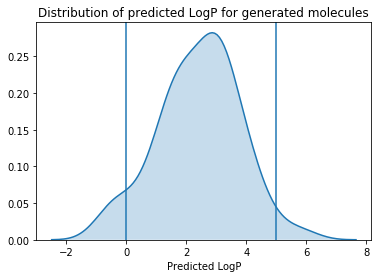

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
C=C(N)c1ccc(C=C2N=C(NN=Cc3ccc(C)cc3)C(=O)CS2)cc1                                      
C=CCC1(C)cc(CNCCCNCCSCc2ccc(N3Cc4c3nc(C(=O)Cc3ccccc3)c(F)c4F)cc2)cc2cc(Oc3ccccc3)nn21 
C=CCCCCCCSC1CCN(Cc2cnn(CC)n2)C(c2cccc(F)c2)SC1                                        
C=CCNC(=O)C(CNC(=O)Nc1cc(F)cc(C(F)(F)F)c1)c1ccc(OCCC(C)C)cc1                          
C=CCSC1=NOC(=S)N1C(C)C(=O)OC                                                          


Policy gradient...: 100%|██████████| 15/15 [00:39<00:00,  2.59s/it]


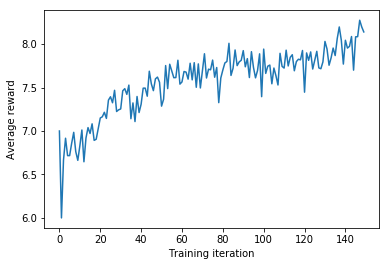

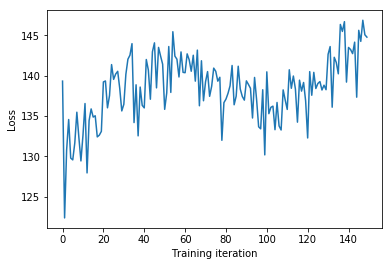

Calculating predictions...: 100%|██████████| 160/160 [00:00<00:00, 1670.51it/s]


Percentage of predictions within drug-like region: 0.86875
Proportion of valid SMILES: 0.8


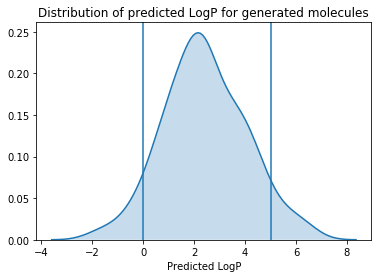

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
C1=N(c2cccc(NCCc3cccnc3)c2)c2ccccc2C1                                              
C=C(C)CCSc1cc(-c2cccc(OC)c2)n[nH]1                                                 
C=CC(C)C=Cc1ccccc1                                                                 
C=CCC(C)(CCCSC(C)=O)C1C(O)CCCC2(C)OC1(C)C1C(O)C2C(C)C(O)CC1C1OC(C)=CC(C)(C)C1C     
C=CCc1c(C)c2c(c(C)c1O)C(=O)CC(c1ccc(OC)cc1)C2=O                                    


Policy gradient...: 100%|██████████| 15/15 [00:37<00:00,  2.49s/it]


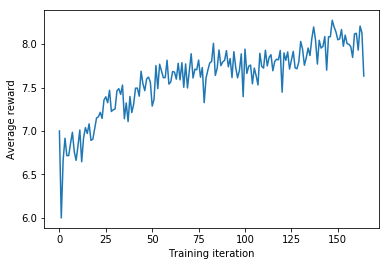

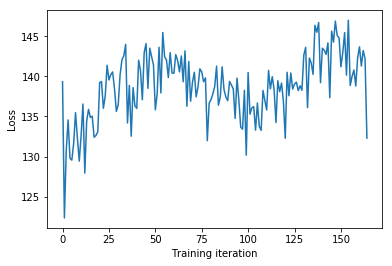

Calculating predictions...: 100%|██████████| 157/157 [00:00<00:00, 1271.17it/s]


Percentage of predictions within drug-like region: 0.9235668789808917
Proportion of valid SMILES: 0.785


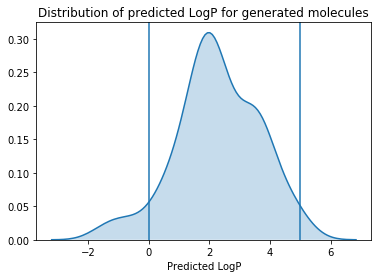

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
C#Cc1cnc(N2CCOCCO2)nc1                                                            
C=C(C)C(O)C1OC2OC(c3ccccc3)C3OC(COC(=O)c4ccc(OC)c(OC)c4)C(O)C3(C)C(O)C21          
C=C(C)CC1NC(=O)CoC(=O)NC(=S)NC1=O                                                 
C=C1Oc2c3c(cc(OC)c(OC)C4(C)CCC(C)(C)C4CC2C1=O)OCO3                                
C=CC(=O)Nc1cccc(S(=O)(=O)N(C)c2ncccn2)c1                                          


Policy gradient...: 100%|██████████| 15/15 [00:37<00:00,  2.41s/it]


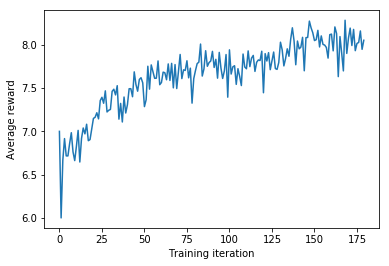

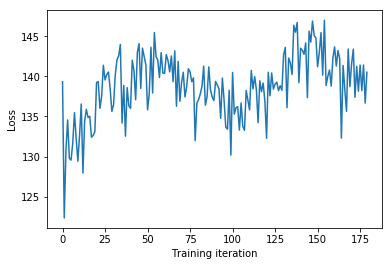

Calculating predictions...:   0%|          | 0/167 [00:00<?, ?it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Calculating predictions...: 100%|██████████| 176/176 [00:00<00:00, 1110.60it/s]


Percentage of predictions within drug-like region: 0.9659090909090909
Proportion of valid SMILES: 0.88


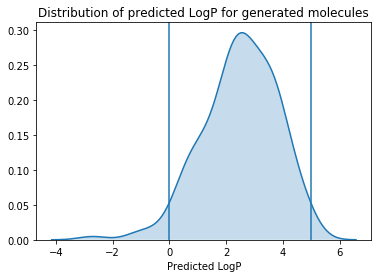

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
C(=NNCCCc1ccccc1)c1ccccc1                                                             
C1=CN(n2cc(-c3ccccn3)cn2)CC1                                                          
C1CC2CCC1CC2                                                                          
C=CCN(C(=O)c1ccc(C(=O)O)cc1)C1=C(N)C(=O)N(CCCC)C1=O                                   
C=CCN(O)C(=O)SC1=NCCS1                                                                


Policy gradient...: 100%|██████████| 15/15 [00:34<00:00,  2.30s/it]


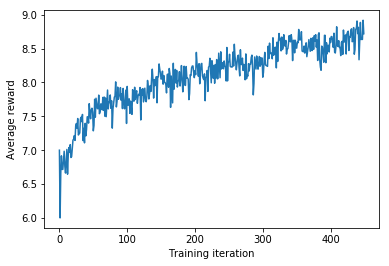

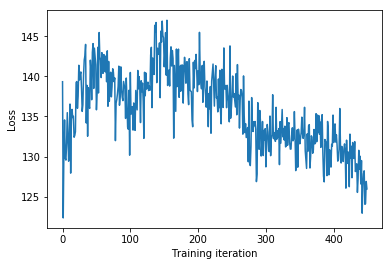

Calculating predictions...: 100%|██████████| 186/186 [00:00<00:00, 1502.17it/s]


Percentage of predictions within drug-like region: 0.967741935483871
Proportion of valid SMILES: 0.93


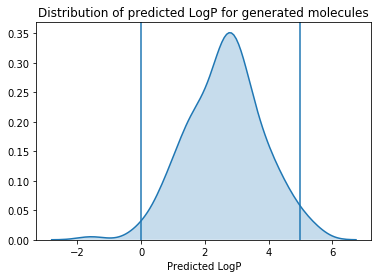

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
C(=C(Nc1ccccc1)c1ccccc1)c1ccccc1                                                   
C=C(C)OC(=O)CCS(=O)CCC=CC                                                          
C=C1CC(Oc2cc(CC(=O)c3ccccc3)ccc2OC)Cc2ccccc21                                      
C=CCN(CCN1CCN(C(=O)Cc2ccccc2)CC1)c1ccccc1                                          
C=CCNC(=O)C1=Cc2cc(O)ccc2C(=O)O1                                                   


Policy gradient...: 100%|██████████| 15/15 [00:33<00:00,  2.18s/it]


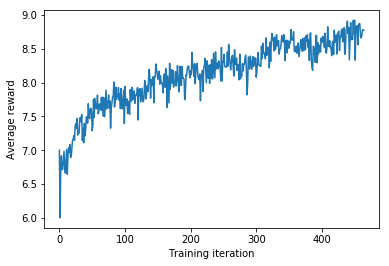

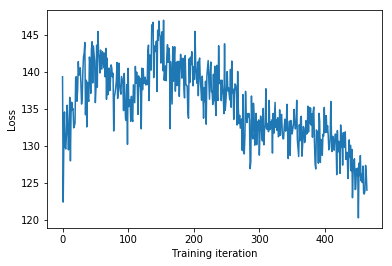

Calculating predictions...: 100%|██████████| 165/165 [00:00<00:00, 1171.29it/s]


Percentage of predictions within drug-like region: 0.9454545454545454
Proportion of valid SMILES: 0.825


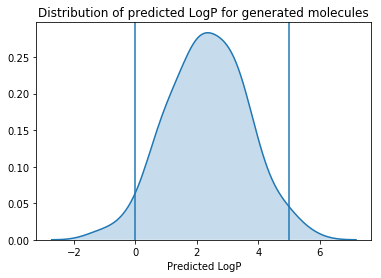

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
C                                                                    
C(=NC1CCCc2ccccc21)Nc1ccccc1                                         
C=CCN(C)c1ccc(C(=O)Nc2cccc(C(=O)O)c2)cc1                             
CC(=NNC(=O)c1ccccc1)N1CCC(C)CC1                                      
CC(=NOCc1ccccc1)c1ccccc1                                             


Policy gradient...: 100%|██████████| 15/15 [00:33<00:00,  2.31s/it]


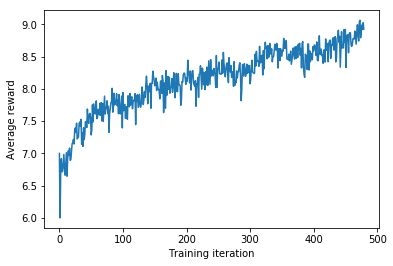

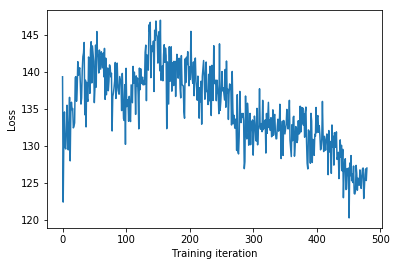

Calculating predictions...: 100%|██████████| 181/181 [00:00<00:00, 922.83it/s]


Percentage of predictions within drug-like region: 0.9502762430939227
Proportion of valid SMILES: 0.905


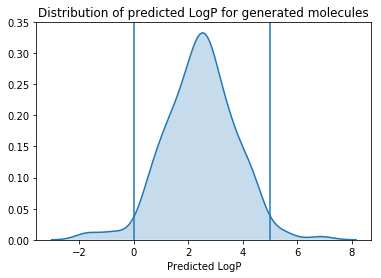

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
C=CCCN1CCCC(c2ccc(C(F)(F)F)cc2)C1                                           
CC(=C1C(=O)Nc2ccccc21)C1CCOCC1                                              
CC(=O)C(=O)c1ccccc1                                                         
CC(=O)COc1ccccc1CN1CCC(N2N=Cc3ccccc3C2=O)CC1                                
CC(=O)N1sc2ccccc21                                                          


Policy gradient...: 100%|██████████| 15/15 [00:32<00:00,  2.15s/it]


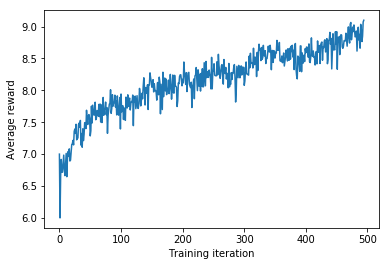

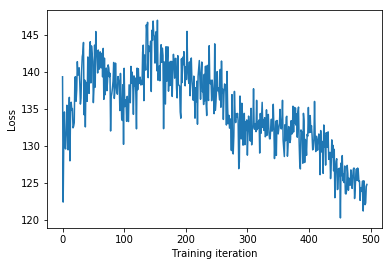

Calculating predictions...: 100%|██████████| 175/175 [00:00<00:00, 1194.35it/s]


Percentage of predictions within drug-like region: 0.9657142857142857
Proportion of valid SMILES: 0.875


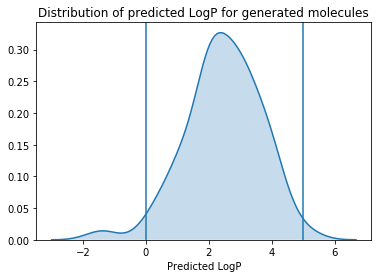

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
C=C1C=C(Cc2ccccc2)c2ccccc2C1=O                                                    
C=CCN1C(=O)cc2sc(-c3cccc(C)c3)cnc2c1NN=Cc1ccccc1                                  
C=CCN1N=C2CCCC1N(Cc1ccccc1)C2                                                     
CBrc1cccc(CNC(=O)COc2ccccc2F)c1                                                   
CC(=Nc1cn2c(C)ccc2c(-c2ccccc2)nn1)c1ccc(N(=O)=O)cc1                               


Policy gradient...: 100%|██████████| 15/15 [00:30<00:00,  2.00s/it]


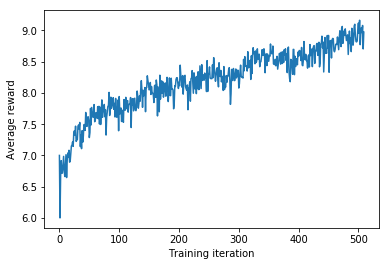

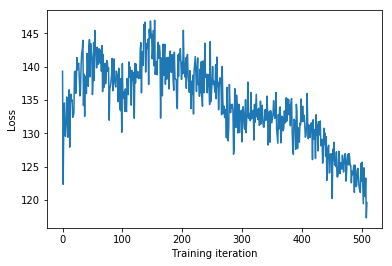

Calculating predictions...: 100%|██████████| 176/176 [00:00<00:00, 1203.47it/s]


Percentage of predictions within drug-like region: 0.9602272727272727
Proportion of valid SMILES: 0.88


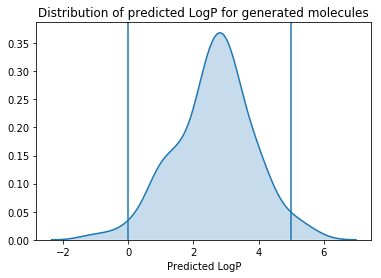

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
C(=C(Cc1ccccc1)c1ccccc1)c1ccccc1                                       
C=CCCCC(NCCC=Cc1ccccc1)c1ccccc1                                        
C=CCOc1c(OC)c(C=NC(=O)Nc2ccccc2)cc2c1C(C)=CC2                          
CC(=NO)c1cn(Cc2ccc(F)cc2)c2c(N)ccnc12                                  
CC(=O)NN=Cc1ccc(OCc2ccccc2C)cc1                                        


Policy gradient...: 100%|██████████| 15/15 [00:29<00:00,  2.00s/it]


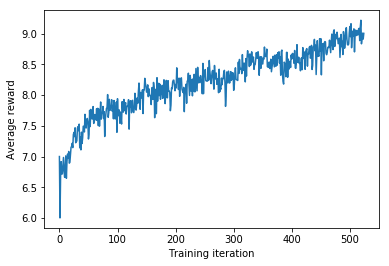

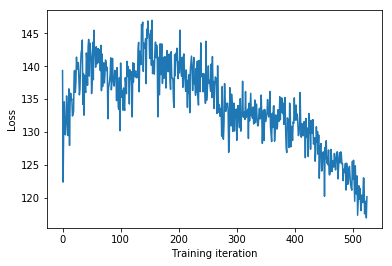

Calculating predictions...: 100%|██████████| 170/170 [00:00<00:00, 1073.32it/s]


Percentage of predictions within drug-like region: 0.9470588235294117
Proportion of valid SMILES: 0.85


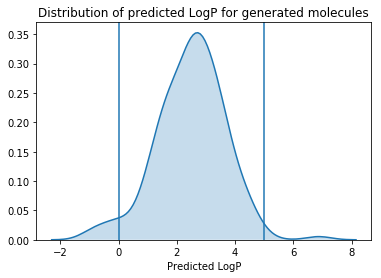

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
C=C1C2C(=O)N(c3ccccc3)C1CN(C(=O)OCCCC)C2c1ccccc1                           
C=CCc1cc(O)c2c(c1OC)OC(C)=C(C)C2(O)C=Cc1ccccc1                             
CC(=Cc1ccccc1)C(=O)c1ccc(O)cc1C                                            
CC(=O)Nc1ccc2c(c1)NC(=O)C(c1ccccc1)=N2                                     
CC(=O)Nc1ccccc1Cn1ccnc1NC(=O)COc1ccccc1                                    


Policy gradient...: 100%|██████████| 15/15 [00:31<00:00,  2.14s/it]


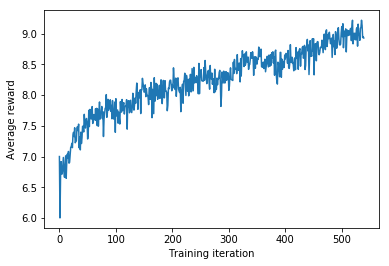

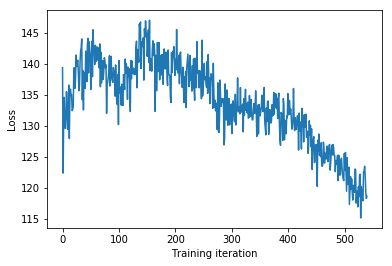

Generating molecules...:  14%|█▍        | 28/200 [00:01<00:07, 24.07it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Calculating predictions...: 100%|██████████| 183/183 [00:00<00:00, 1318.71it/s]


Percentage of predictions within drug-like region: 0.9781420765027322
Proportion of valid SMILES: 0.915


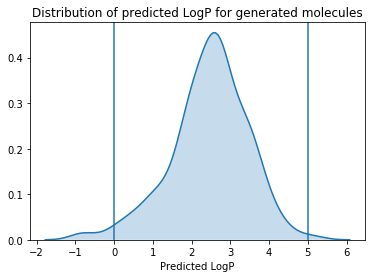

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
C#CCCN1C(=O)N(c2cccc(OC)c2)c2ccccc21                          
C=CCNC(=O)c1ccccc1SC                                          
CC(=O)N1CCN(C(=O)c2ccc3ccccc3c2)CC1                           
CC(=O)NCCCN1CCCCC1C(=O)NC(C(=O)c1ccccc1)C1CCCNC1=O            
CC(=O)Nc1ccccc1C(=O)c1ccccc1                                  


Policy gradient...: 100%|██████████| 15/15 [00:27<00:00,  1.86s/it]


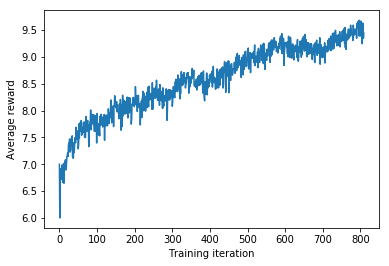

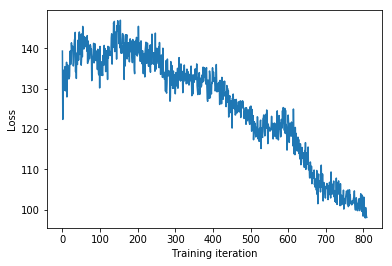

Calculating predictions...: 100%|██████████| 190/190 [00:00<00:00, 1185.27it/s]


Percentage of predictions within drug-like region: 0.9736842105263158
Proportion of valid SMILES: 0.95


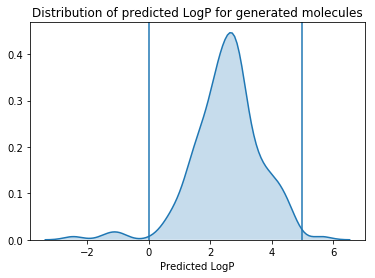

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
C=CCc1c2ccccc2Sc2ccccc2CO1                                                      
CC(=NN1CCN(CC2CC2)c2ccccc21)c1ccccc1                                            
CC(=O)NCc1ccccc1                                                                
CC(=O)Nc1ccc(CN2CCCC(=O)c3ccccc32)cc1                                           
CC(=O)Nc1ccccc1CNc1ccccc1C(=O)NC1CCCC1                                          


Policy gradient...: 100%|██████████| 15/15 [00:29<00:00,  1.97s/it]


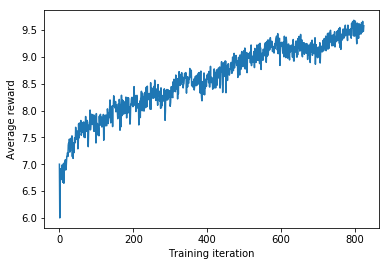

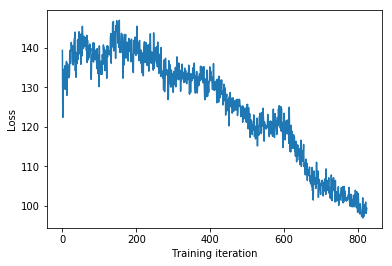

Calculating predictions...: 100%|██████████| 180/180 [00:00<00:00, 1379.52it/s]


Percentage of predictions within drug-like region: 0.9833333333333333
Proportion of valid SMILES: 0.9


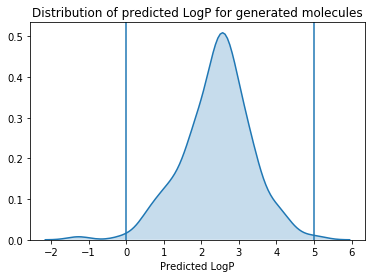

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
CC(=O)NCCCCCN1CC(c2ccccc2)Oc2ccccc2C1=O                                                               
CC(=O)Nc1ccccc1                                                                                       
CC(=O)Oc1ccccc1C(=O)c1ccccc1                                                                          
CC(=O)Oc1ccccc1CCNC(=O)COc1ccccc1                                                                     
CC(=O)c1ccccc1C(=O)c1ccccc1                                                                           


Policy gradient...: 100%|██████████| 15/15 [00:27<00:00,  1.68s/it]


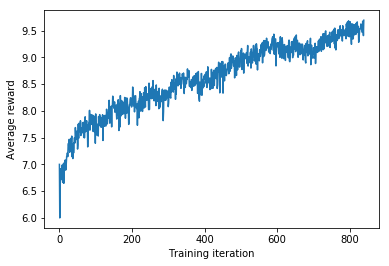

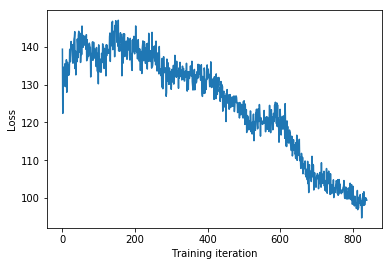

Calculating predictions...: 100%|██████████| 180/180 [00:00<00:00, 1068.93it/s]


Percentage of predictions within drug-like region: 0.9888888888888889
Proportion of valid SMILES: 0.9


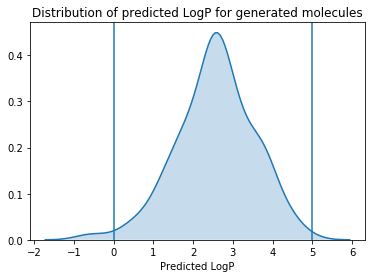

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
C=CCOc1ccccc1COC(=O)c1ccccc1                                         
CC(=O)Nc1cccc2ccccc12                                                
CC(=O)Nc1ccccc1Cl                                                    
CC(=O)Nc1ccccc1NC(=O)c1ccccc1O                                       
CC(=O)Nc1nc2ccccc2s1                                                 


Policy gradient...: 100%|██████████| 15/15 [00:27<00:00,  1.99s/it]


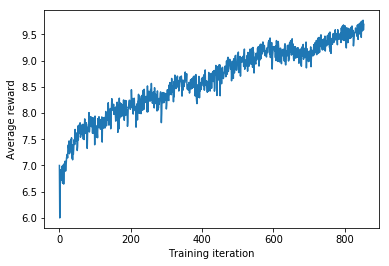

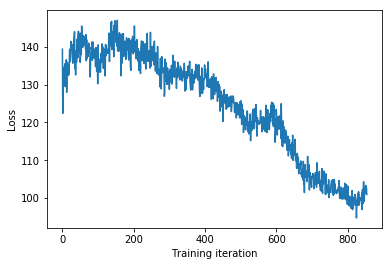

Calculating predictions...: 100%|██████████| 178/178 [00:00<00:00, 1658.18it/s]


Percentage of predictions within drug-like region: 0.9943820224719101
Proportion of valid SMILES: 0.89


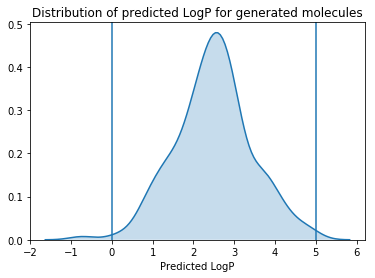

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
C=CCC1CC2CCCC(c3ccccc3N1)N2C(=O)c1c(OC)ccc2ncccc12
CC(=O)NCc1ccccc1                                  
CC(=O)Nc1ccc2c(nc3ccccc32)C1=O                    
CC(=O)OCC(CC(=O)Nc1ccccc1)c1ccccc1                
CC(=O)Oc1ccccc1CC(=O)Nc1ccccc1                    


Policy gradient...: 100%|██████████| 15/15 [00:27<00:00,  1.90s/it]


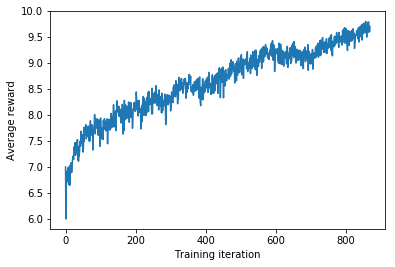

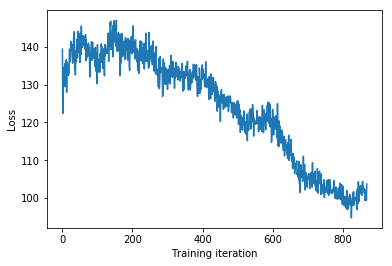

Calculating predictions...: 100%|██████████| 179/179 [00:00<00:00, 1325.60it/s]


Percentage of predictions within drug-like region: 0.9720670391061452
Proportion of valid SMILES: 0.895


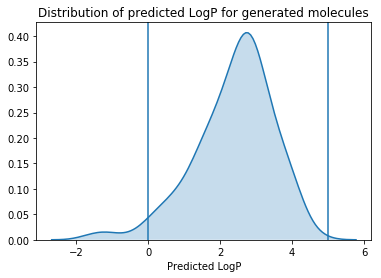

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
C#CCc1ccccc1CCc1ccccc1                                      
C=C1C(=O)N(C)C(C)CN1CC(O)CN1CC(C)c2ccccc2O1                 
C=CCN(C=Cc1ccccc1)C(=O)CC1CCN(c2ccccc2)CC1                  
C=CCN(Cc1ccccc1)C(=O)c1ccccc1                               
CC(=O)Nc1ccc2c(c1)C=CC(=O)N2                                


Policy gradient...: 100%|██████████| 15/15 [00:27<00:00,  1.84s/it]


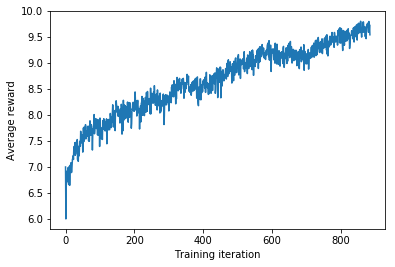

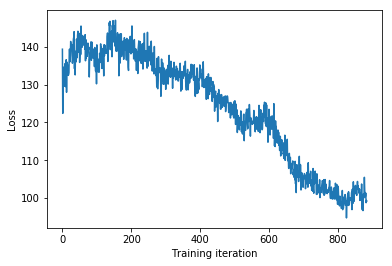

Calculating predictions...: 100%|██████████| 177/177 [00:00<00:00, 1172.59it/s]


Percentage of predictions within drug-like region: 0.9661016949152542
Proportion of valid SMILES: 0.885


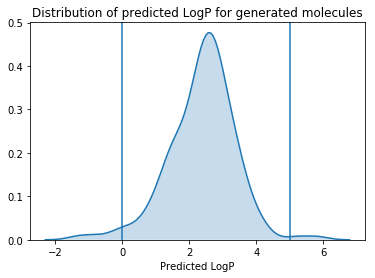

Policy gradient...:   0%|          | 0/15 [00:00<?, ?it/s]

Sample trajectories:
C=C1CC(C(=O)N2CCN(C)CC2)C(C)(C(C)NN=Cc2ccccc2)N1    
C=CCC1ON=Cc2(cccc(C(=O)O)c2)S1                      
CC(=O)C(=Cc1ccccc1)c1ccccc1                         
CC(=O)Nc1ccc2ccccc2n1                               
CC(=O)Nc1ccccc1                                     


Policy gradient...: 100%|██████████| 15/15 [00:25<00:00,  1.75s/it]


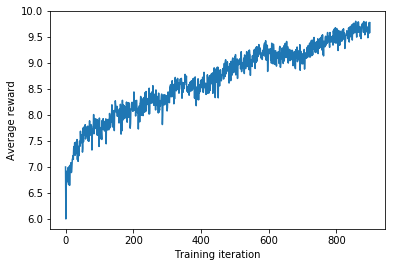

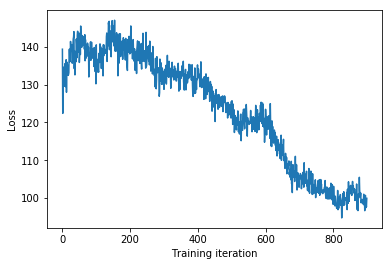

Generating molecules...:  100%|████████| 200/200 [00:03<00:03, 28.65it/s]


In [36]:
for i in range(n_iterations):
    for j in trange(n_policy, desc='Policy gradient...'):
        cur_reward, cur_loss = RL_logp.policy_gradient(gen_data)
        rewards.append(simple_moving_average(rewards, cur_reward)) 
        rl_losses.append(simple_moving_average(rl_losses, cur_loss))
    
    plt.plot(rewards)
    plt.xlabel('Training iteration')
    plt.ylabel('Average reward')
    plt.show()
    plt.plot(rl_losses)
    plt.xlabel('Training iteration')
    plt.ylabel('Loss')
    plt.show()
        
    smiles_cur, prediction_cur = estimate_and_update(RL_logp.generator, 
                                                     my_predictor, 
                                                     n_to_generate)
    print('Sample trajectories:')
    for sm in smiles_cur[:5]:
        print(sm)

Calculating predictions...: 100%|██████████| 6894/6894 [00:04<00:00, 1492.81it/s]


Percentage of predictions within drug-like region: 0.979982593559617
Proportion of valid SMILES: 0.6894


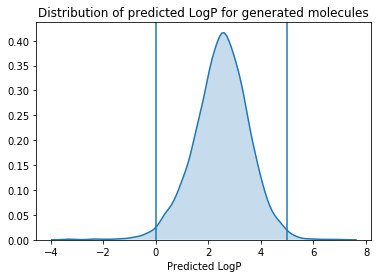

In [37]:
smiles_biased, prediction_biased = estimate_and_update(RL_logp.generator, 
                                                       my_predictor,
                                                       n_to_generate=10000)

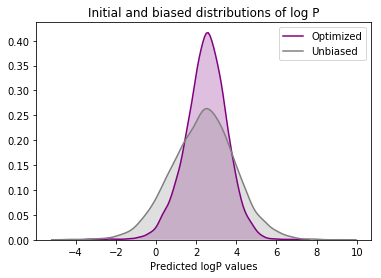

In [38]:
sns.kdeplot(prediction_biased, label='Optimized', shade=True, color='purple')
sns.kdeplot(prediction_unbiased, label='Unbiased', shade=True, color='grey')
plt.xlabel('Predicted logP values')
plt.title('Initial and biased distributions of log P')
plt.legend()
plt.show()

### Drawing random molecules

Now we will draw some random compounds from the biased library:

In [39]:
from rdkit.Chem import Draw

In [40]:
from rdkit.Chem.Draw import DrawingOptions
from rdkit.Chem import Draw
DrawingOptions.atomLabelFontSize = 50
DrawingOptions.dotsPerAngstrom = 100
DrawingOptions.bondLineWidth = 3

In [41]:
generated_mols = [Chem.MolFromSmiles(sm, sanitize=True) for sm in smiles_biased]

In [42]:
sanitized_gen_mols = [generated_mols[i] for i in np.where(np.array(generated_mols) != None)[0]]

In [43]:
n_to_draw = 20
ind = np.random.randint(0, len(sanitized_gen_mols), n_to_draw)
mols_to_draw = [sanitized_gen_mols[i] for i in ind]
legends = ['log P = ' + str(prediction_biased[i]) for i in ind]

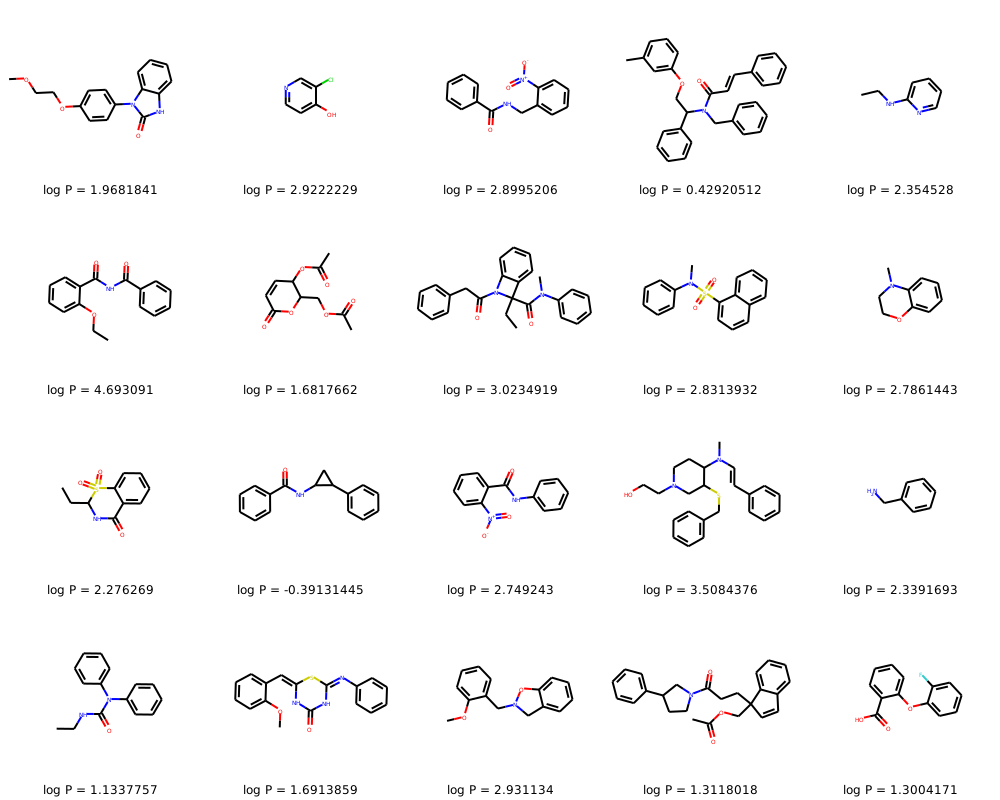

In [44]:
Draw.MolsToGridImage(mols_to_draw, molsPerRow=5, 
                     subImgSize=(200,200), legends=legends)